In [30]:
# imports and setup
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('seaborn-v0_8')
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [19]:
# Constants 
SENTIMENT = 'review_score'
NEGATIVE_SENTIMENT = '#e15759'
POSITIVE_SENTIMENT = '#4e79a7'
SENTIMENT_PALLETTE = {-1: NEGATIVE_SENTIMENT, 1: POSITIVE_SENTIMENT }

### 1 - Data Acquisition: Import the Dataset from Kaggle
- Dataset (Kaggle): [steam-reviews](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data)

- Dataset (local): [data/dataset.csv](data/dataset.csv)


In [ ]:
path = kagglehub.dataset_download("andrewmvd/steam-reviews")

In [ ]:
path

'C:\\Users\\Fatema\\.cache\\kagglehub\\datasets\\andrewmvd\\steam-reviews\\versions\\3'

In [ ]:
! copy $path\dataset.csv data\

# on unix terminal use
# ! cp $path\dataset.csv data\

        1 file(s) copied.


In [ ]:
df = pd.read_csv('data/dataset.csv')

In [6]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [8]:
df.describe()

,app_id,review_score,review_votes
count,6.417106e+06,6.417106e+06,6.417106e+06
mean,2.274695e+05,6.394992e-01,1.472446e-01
std,1.260451e+05,7.687918e-01,3.543496e-01
min,1.000000e+01,-1.000000e+00,0.000000e+00
25%,2.018100e+05,1.000000e+00,0.000000e+00
50%,2.391600e+05,1.000000e+00,0.000000e+00
75%,3.056200e+05,1.000000e+00,0.000000e+00
max,5.653400e+05,1.000000e+00,1.000000e+00


### 2- EDA

In [18]:
print('Number of games reviewed: {}'.format(df['app_id'].nunique())) # how many games are there?

Number of games reviewed: 9972


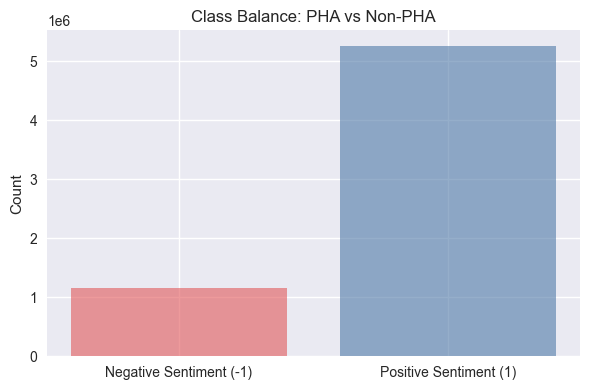

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
counts = df[SENTIMENT].value_counts().sort_index()
ax.bar(x=['Negative Sentiment (-1)', 'Positive Sentiment (1)'],height=counts.values, color=[NEGATIVE_SENTIMENT,POSITIVE_SENTIMENT], alpha=0.6)
ax.set_title('Class Balance: PHA vs Non-PHA')
ax.set_ylabel('Count')
fig.tight_layout()
plt.savefig('figures/sentiment_class_balance.png')

In [ ]:
def make_balanced_subset_500k(
    csv_path: str = "data/dataset.csv",
    score_col: str = "review_score",
    classes: tuple = (-1, 1),
    total_target: int = 500_000,
    random_state: int = 42,
    save_path: str = "data/new_dataset",
    save_format: str = "csv",
    oversample_if_needed: bool = True
) -> pd.DataFrame:
    """
    Create a balanced subset of size `total_target` across `classes`.
    If any class has < target_per_class, optionally oversample with replacement.

    Returns the balanced DataFrame. Optionally saves to Parquet/CSV.
    """
    assert total_target % len(classes) == 0, "total_target must be divisible by number of classes."
    target_per_class = total_target // len(classes)

    # 1) Load
    df = pd.read_csv(csv_path)

    # 2) Keep only the desired classes (robust to stray values)
    df = df[df[score_col].isin(classes)].copy()

    # 3) Count per class
    counts = df[score_col].value_counts().reindex(classes).fillna(0).astype(int)
    print("Class counts before balancing:", counts.to_dict())

    # 4) For each class: sample appropriately
    parts = []
    for c in classes:
        df_c = df[df[score_col] == c]

        if len(df_c) >= target_per_class:
            # Downsample without replacement
            part = df_c.sample(n=target_per_class, replace=False, random_state=random_state)
        else:
            if oversample_if_needed:
                # Sample with replacement to reach target
                part = df_c.sample(n=target_per_class, replace=True, random_state=random_state)
                print(f"Warning: Class {c} had only {len(df_c)} rows; oversampling with replacement to {target_per_class}.")
            else:
                # Take what we have (no replacement), and total will be smaller than requested
                part = df_c.sample(n=len(df_c), replace=False, random_state=random_state)
                print(f"Notice: Class {c} limited to {len(df_c)} rows (no oversampling).")

        parts.append(part)

    # 5) Concatenate, shuffle, reset index
    balanced = pd.concat(parts, axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # 6) Verify
    final_counts = balanced[score_col].value_counts().reindex(classes).fillna(0).astype(int)
    print("Class counts after balancing:", final_counts.to_dict())
    print("Final size:", len(balanced))

    # 7) Optional save
    if save_path:
        if save_format.lower() == "parquet":
            balanced.to_parquet(save_path, index=False)
        elif save_format.lower() == "csv":
            balanced.to_csv(save_path, index=False)
        else:
            raise ValueError("save_format must be 'parquet' or 'csv'.")
        print(f"Saved to {save_path}")

    return balanced

balanced_df = make_balanced_subset_500k(
    csv_path="data/dataset.csv",
    score_col="review_score",
    classes=(-1, 1),
    total_target=500_000,
    random_state=42,
    save_path="data/dataset_balanced_500k.csv",
    save_format="parquet",
    oversample_if_needed=True,
)


Class counts before balancing: {-1: 1156686, 1: 5260420}
Class counts after balancing: {-1: 250000, 1: 250000}
Final size: 500000
Saved to data/dataset_balanced_500k.csv


In [22]:
# Explore Sentiment (review_score) class balance

### 3- Data Preprocessing

In [ ]:
df_truncated = df['']

### 4- Model Training

### 5- Results Evaluations